# 气候观察者模型


In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

from pathlib import Path
import pandas as pd
import numpy as np

/Users/songshgeo/Documents/VSCode/past1000/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/songshgeo/Documents/VSCode/past1000/.venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
[16:47:09][WARNING][datacollector] No final reporters have been definedreturning empty DataFrame.


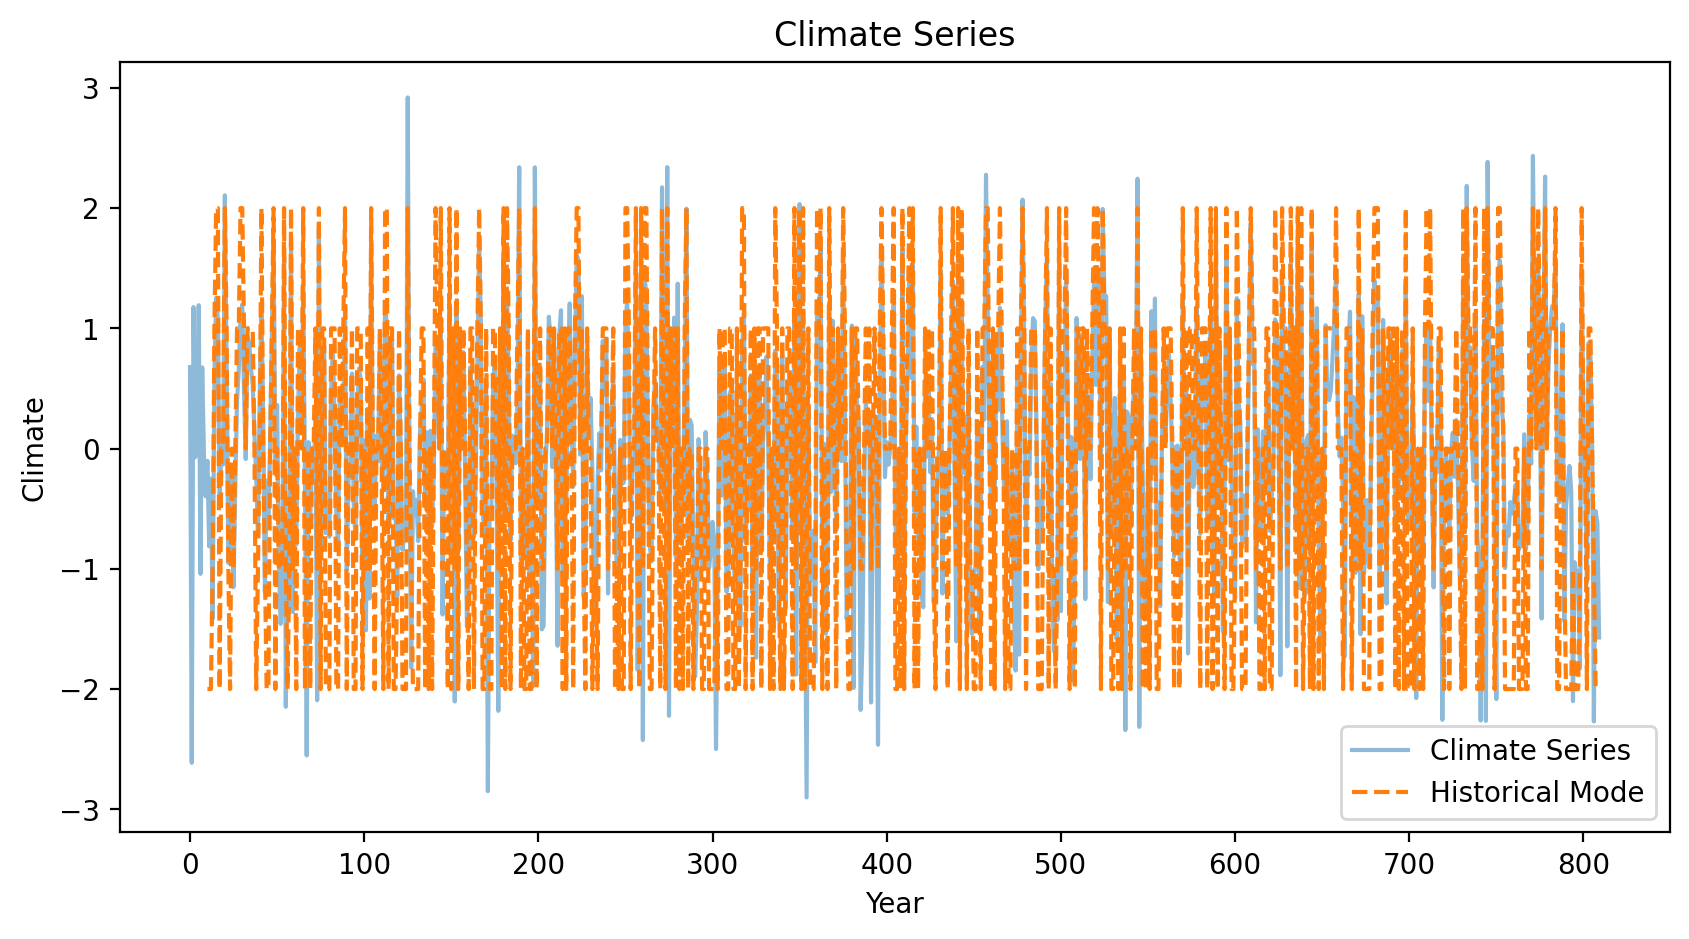

In [8]:
from past1000.abm import Model
import matplotlib.pyplot as plt

# 运行模型
parameters = {
    "years": 300,
    "max_age": 60,
    "loss_rate": 0.4,
    "new_agents": 10,
    "min_age": 10,
    "rejudge": False,
}
model = Model(parameters={"model": parameters})
model.run_model()

# 绘制气候序列和历史平均
fig, ax = plt.subplots(figsize=(10, 5))
model.climate_series.plot(ax=ax, label="Climate Series", alpha=0.5)
model.mode.plot(ax=ax, label="Historical Mode", linestyle="--")
ax.set_title("Climate Series")
ax.set_xlabel("Year")
ax.set_ylabel("Climate")
ax.legend()
plt.show();

In [12]:
model.estimation

,value,expect,classified
510,0.607874,1.0,1
511,-0.088258,0.0,0
512,0.939895,1.0,1
513,0.707692,1.0,1
514,-1.251336,-1.0,-2
...,...,...,...
804,0.787018,1.0,1
805,0.042245,0.0,0
806,-2.269161,-1.0,-2
807,-0.519034,-2.0,-1


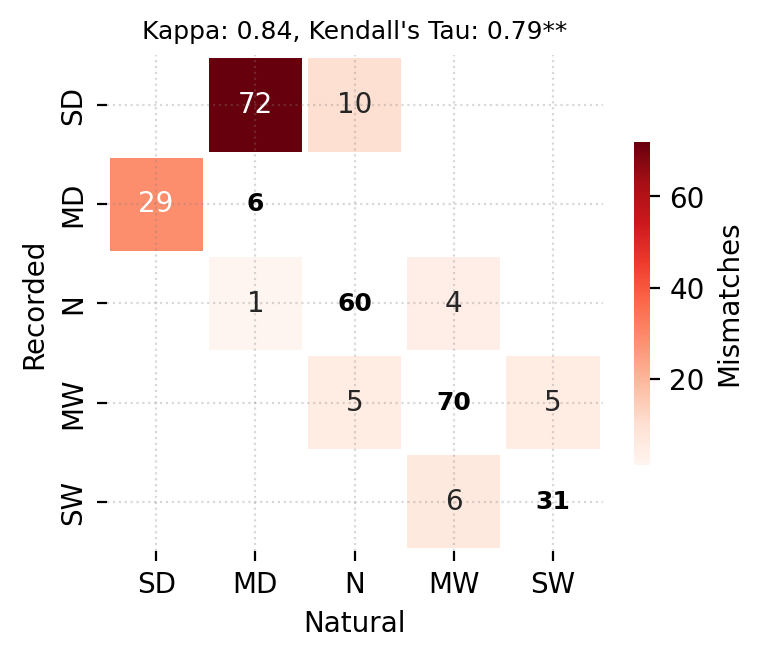

In [14]:
from past1000.calibration import (
    analyze_mismatch,
    notna_confusion_matrix,
    mismatch_stats,
    dropna_series,
)
from past1000.utils.plot import plot_confusion_matrix
from past1000.constants import TICK_LABELS
from past1000.abm import Model


cm_df = notna_confusion_matrix(
    y_true=model.estimation["classified"],
    y_pred=model.estimation["expect"],
    labels=TICK_LABELS,
    dropna=True,
)
title = mismatch_stats(
    y_true=model.estimation["classified"],
    y_pred=model.estimation["expect"],
    as_str=True,
)
plot_confusion_matrix(cm_df=cm_df, title=title);

  0%|          | 0/100 [00:00<?, ?it/s]

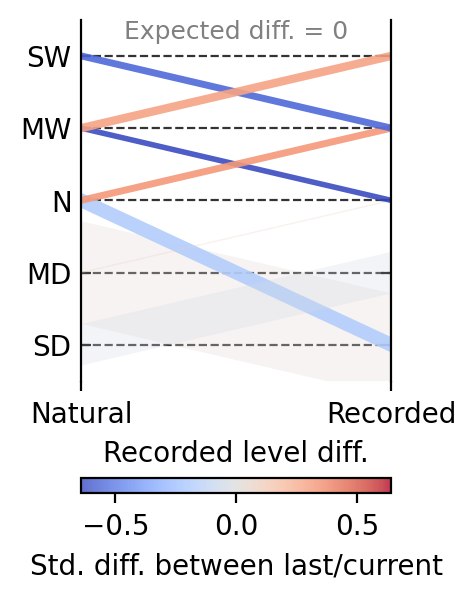

In [15]:
from past1000.calibration import analyze_mismatch

analyze_mismatch(
    model.estimation["value"],
    model.estimation["expect"],
    cm_df,
    plot="flowmap",
);

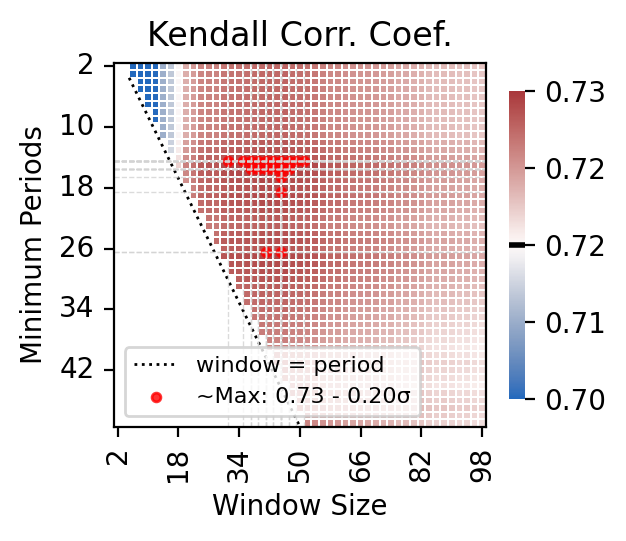

In [16]:
from past1000.compare import experiment_corr_2d
from past1000.filters import calc_std_deviation

filtered, r_benchmark, ax = experiment_corr_2d(
    model.mode,
    model.climate_series,
    filter_func=calc_std_deviation,
    corr_method="kendall",
    filter_side="right",
)

/Users/songshgeo/Documents/VSCode/past1000/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/songshgeo/Documents/VSCode/past1000/.venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


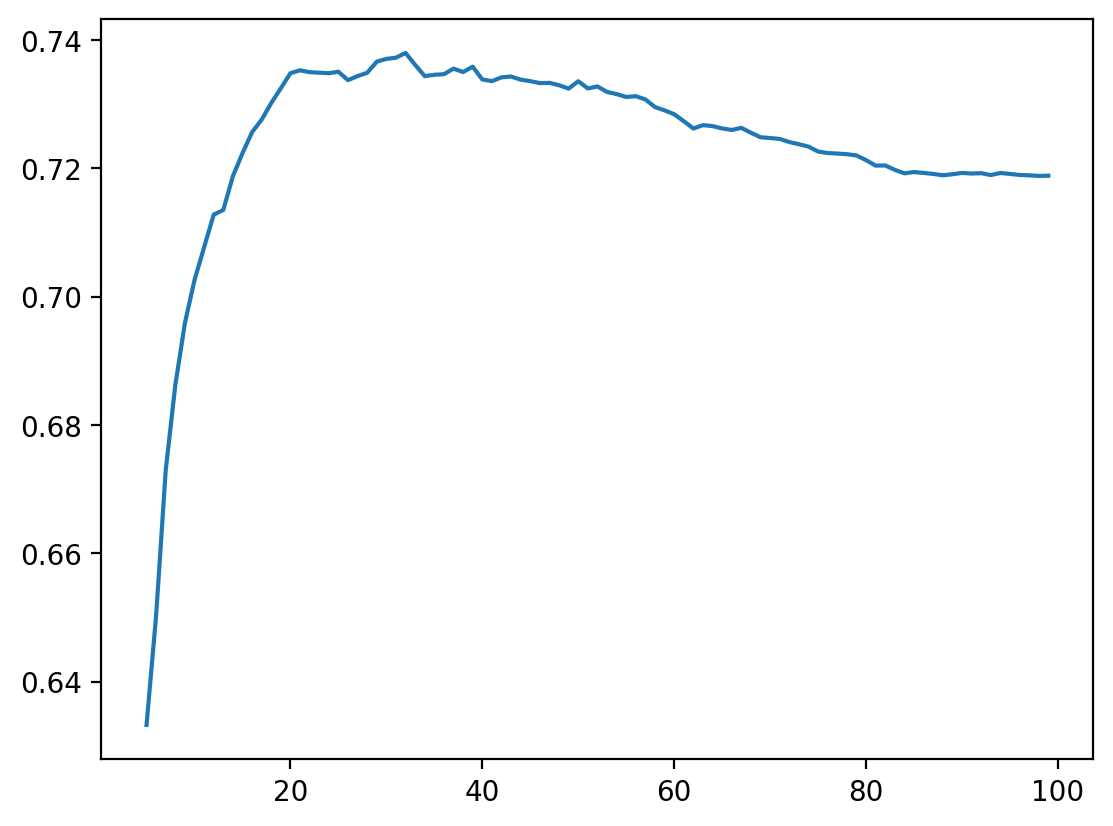

In [17]:
from past1000.compare import compare_corr_2d
from past1000.filters import calc_std_deviation

windows = np.arange(2, 100)
min_periods = np.repeat(2, 98)

rs, ps, ns = compare_corr_2d(
    model.historical_mean,
    model.climate_series,
    windows=windows,
    min_periods=min_periods,
    filter_func=calc_std_deviation,
    corr_method="kendall",
    filter_side="right",
)
plt.plot(windows, rs)

## 读取模型结果

In [27]:
import yaml

path = Path("../multirun/2025-07-08/17-11-05")
datasets = []

for subdir in path.iterdir():
    if subdir.is_dir():
        corr_file = subdir / "correlations.csv"
        hydra_config = subdir / ".hydra" / "overrides.yaml"
        if corr_file.exists() and hydra_config.exists():
            # 读取 correlations.csv
            df = pd.read_csv(corr_file, index_col=0)
            long = df.melt(ignore_index=False).reset_index()
            long["run"] = subdir.name

            # 读取 hydra 配置
            with open(hydra_config, "r") as f:
                overrides = yaml.safe_load(f)
            # 解析每个参数
            param_dict = {}
            for item in overrides:
                if "=" in item:
                    key, value = item.split("=", 1)
                    # 只保留 how. 开头的参数（可选）
                    if key.startswith("how."):
                        key = key.replace("how.", "")
                    param_dict[key] = value
            # 将参数字典展开为多列
            for k, v in param_dict.items():
                long[k] = v

            datasets.append(long)

# 合并所有数据
df_all = pd.concat(datasets, ignore_index=True)
# 1. 找每个 (rejudge, max_age, run) 下最大 correlation 的 Year
# 假设 df_all 已经有 'max_age', 'rejudge', 'variable', 'index', 'value'
df_all["index"] = df_all["index"].astype(int)
df_all["max_age"] = df_all["max_age"].astype(int) - df_all["min_age"].astype(int)
df_all.head()

,index,variable,value,run,how,max_age,rejudge,min_age
0,2,model_0,NaN,32,abm,35,True,20
1,3,model_0,NaN,32,abm,35,True,20
2,4,model_0,NaN,32,abm,35,True,20
3,5,model_0,NaN,32,abm,35,True,20
4,6,model_0,NaN,32,abm,35,True,20


In [28]:
# 找到每组最大 correlation 的 Year
def get_max_row(group):
    idxmax = group["value"].idxmax()
    return group.loc[idxmax, ["index", "value"]]


max_points = (
    df_all.groupby(["max_age", "rejudge", "min_age"])
    # df_all.groupby(["new_agents", "loss_rate"])
    .apply(get_max_row)
    .reset_index()
    .rename(columns={"index": "Year", "value": "MaxCorrelation"})
)
max_points["max_age"] = max_points["max_age"].astype(int) - max_points[
    "min_age"
].astype(int)
max_points.head()

/var/folders/s9/w7bh_d6x1h915wcvpbp117tm0000gn/T/ipykernel_1806/3353103551.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(get_max_row)


,max_age,rejudge,min_age,Year,MaxCorrelation
0,-10,False,20,17,0.758973
1,-10,True,20,13,0.837936
2,0,False,15,16,0.761992
3,-5,False,20,19,0.757825
4,0,True,15,14,0.844818


In [9]:
import seaborn as sns

# 假设你的 DataFrame 叫 df

# Year 的均值透视表
pivot_year = max_points.pivot_table(
    index="new_agents", columns="loss_rate", values="Year", aggfunc="mean"
)

# MaxCorrelation 的均值透视表
pivot_corr = max_points.pivot_table(
    index="new_agents", columns="loss_rate", values="MaxCorrelation", aggfunc="mean"
)
pivot_corr.head()

KeyError: 'new_agents'

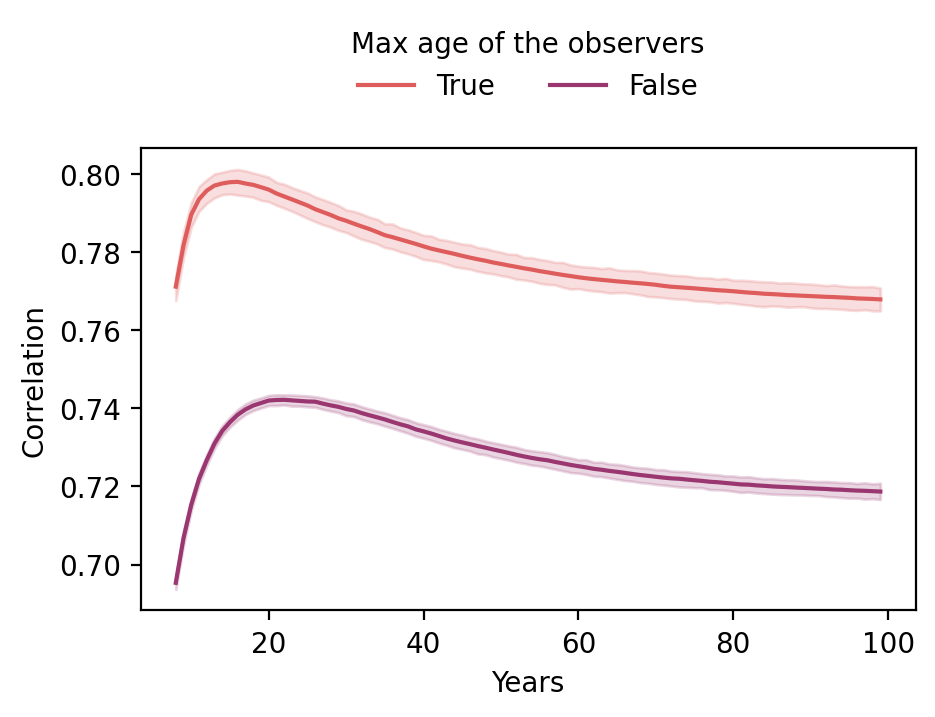

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# subset = df_all[df_all["rejudge"] == "True"]
fig, ax = plt.subplots(figsize=(5, 3))
sns.lineplot(
    data=df_all,
    x="index",
    y="value",
    hue="rejudge",
    estimator=np.mean,
    palette="flare",
)
ax.set_xlabel("Years")
ax.set_ylabel("Correlation")
ax.legend(
    ncol=3,
    loc="lower center",
    bbox_to_anchor=(0.5, 1.05),
    frameon=False,
    title="Max age of the observers",
)
plt.show();

/var/folders/s9/w7bh_d6x1h915wcvpbp117tm0000gn/T/ipykernel_1806/1755981229.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.loc[g["value"].idxmax(), "index"])


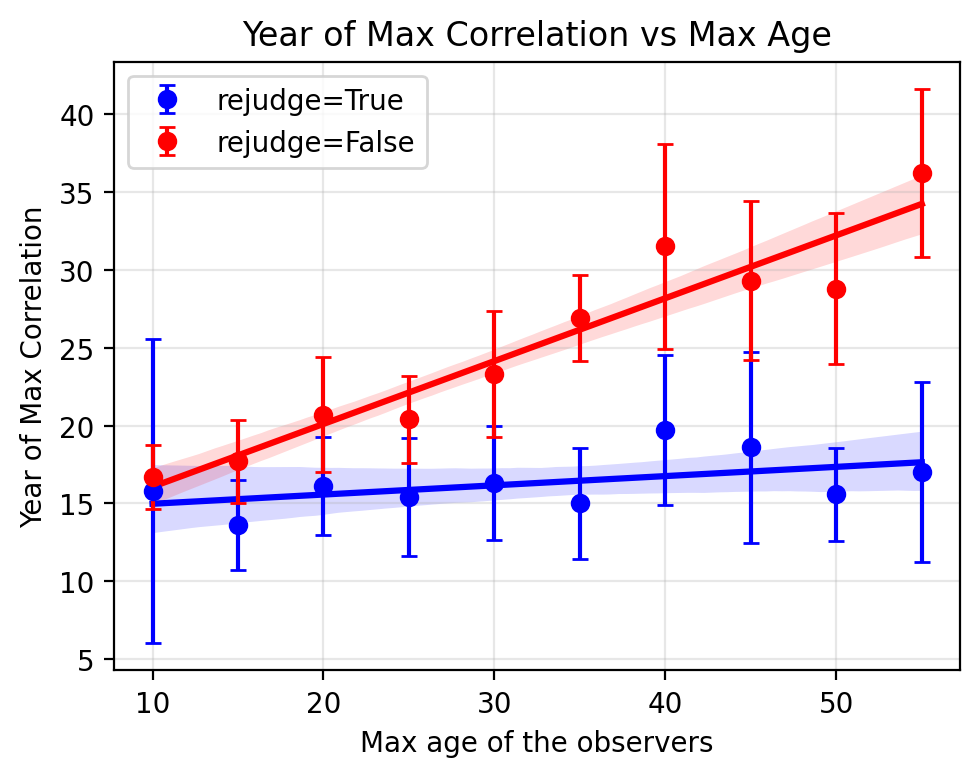

In [53]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 以 ['rejudge', 'max_age', 'variable'] 分组，找每个重复的最大相关性出现的 Year
max_years = (
    df_all.groupby(["rejudge", "max_age", "variable"])
    .apply(lambda g: g.loc[g["value"].idxmax(), "index"])
    .reset_index(name="max_corr_year")
)

# 2. 统计每组（rejudge, max_age）下最大 Year 的均值和标准差
summary = (
    max_years.groupby(["rejudge", "max_age"])["max_corr_year"]
    .agg(["mean", "std", "count"])
    .reset_index()
)

# 3. 绘图
plt.figure(figsize=(5, 4))
ax = plt.gca()

# 使用 scatterplot + errorbar 替代 pointplot
for rejudge_val, color in zip(["True", "False"], ["blue", "red"]):
    subset = max_years[max_years["rejudge"] == rejudge_val]

    # 计算每个 max_age 的均值和标准差
    stats = (
        subset.groupby("max_age")["max_corr_year"].agg(["mean", "std"]).reset_index()
    )

    # 绘制错误棒
    ax.errorbar(
        stats["max_age"],
        stats["mean"],
        yerr=stats["std"],
        fmt="o",
        color=color,
        capsize=3,
        label=f"rejudge={rejudge_val}",
    )

    # 添加回归线
    sns.regplot(
        data=subset,
        x="max_age",
        y="max_corr_year",
        scatter=False,
        color=color,
        ax=ax,
    )

plt.ylabel("Year of Max Correlation")
plt.xlabel("Max age of the observers")
plt.title("Year of Max Correlation vs Max Age")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show();